In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import xgboost as xb
from sklearn.linear_model import LinearRegression
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline, FunctionTransformer
pd.set_option('display.max_columns', 5000)
sns.set_style('dark')

# Data Parsing & EDA:

In [2]:
# Loading the data:
csv_path = './artifacts/data_ingestion/Australian Vehicle Prices.csv'
df = pd.read_csv(csv_path)
df_backup = df.copy(deep=True)
# looking at the data and determining parsing actions:
display(df.info())
display(df.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16734 entries, 0 to 16733
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Brand              16733 non-null  object 
 1   Year               16733 non-null  float64
 2   Model              16733 non-null  object 
 3   Car/Suv            16706 non-null  object 
 4   Title              16733 non-null  object 
 5   UsedOrNew          16733 non-null  object 
 6   Transmission       16733 non-null  object 
 7   Engine             16733 non-null  object 
 8   DriveType          16733 non-null  object 
 9   FuelType           16733 non-null  object 
 10  FuelConsumption    16733 non-null  object 
 11  Kilometres         16733 non-null  object 
 12  ColourExtInt       16733 non-null  object 
 13  Location           16284 non-null  object 
 14  CylindersinEngine  16733 non-null  object 
 15  BodyType           16452 non-null  object 
 16  Doors              151

None

,Brand,Year,Model,Car/Suv,Title,UsedOrNew,Transmission,Engine,DriveType,FuelType,FuelConsumption,Kilometres,ColourExtInt,Location,CylindersinEngine,BodyType,Doors,Seats,Price
0,Ssangyong,2022.0,Rexton,Sutherland Isuzu Ute,2022 Ssangyong Rexton Ultimate (awd),DEMO,Automatic,"4 cyl, 2.2 L",AWD,Diesel,8.7 L / 100 km,5595,White / Black,"Caringbah, NSW",4 cyl,SUV,4 Doors,7 Seats,51990
1,MG,2022.0,MG3,Hatchback,2022 MG MG3 Auto Excite (with Navigation),USED,Automatic,"4 cyl, 1.5 L",Front,Premium,6.7 L / 100 km,16,Black / Black,"Brookvale, NSW",4 cyl,Hatchback,5 Doors,5 Seats,19990
2,BMW,2022.0,430I,Coupe,2022 BMW 430I M Sport,USED,Automatic,"4 cyl, 2 L",Rear,Premium,6.6 L / 100 km,8472,Grey / White,"Sylvania, NSW",4 cyl,Coupe,2 Doors,4 Seats,108988
3,Mercedes-Benz,2011.0,E500,Coupe,2011 Mercedes-Benz E500 Elegance,USED,Automatic,"8 cyl, 5.5 L",Rear,Premium,11 L / 100 km,136517,White / Brown,"Mount Druitt, NSW",8 cyl,Coupe,2 Doors,4 Seats,32990
4,Renault,2022.0,Arkana,SUV,2022 Renault Arkana Intens,USED,Automatic,"4 cyl, 1.3 L",Front,Unleaded,6 L / 100 km,1035,Grey / Black,"Castle Hill, NSW",4 cyl,SUV,4 Doors,5 Seats,34990
5,Toyota,2004.0,Estima,ON FOUR WHEELS,2004 Toyota Estima T EDITION,USED,Automatic,-,Other,Unleaded,-,160230,Grey / -,"Saint Marys, NSW",-,Commercial,NaN,NaN,9990
6,Land,2017.0,Rover,SUV,2017 Land Rover Range Rover Evoque TD4 180 HSE...,USED,Automatic,"4 cyl, 2 L",AWD,Diesel,5.1 L / 100 km,67662,White / Black,"Blacktown, NSW",4 cyl,SUV,2 Doors,4 Seats,62280
7,Nissan,2000.0,Pulsar,Hatchback,2000 Nissan Pulsar LX,USED,Automatic,"4 cyl, 1.6 L",Front,Unleaded,8 L / 100 km,300539,Red / Grey,"Wentworthville, NSW",4 cyl,Hatchback,5 Doors,5 Seats,2995
8,Toyota,2013.0,86,Coupe,2013 Toyota 86 GT,USED,Automatic,"4 cyl, 2 L",Rear,Premium,7.1 L / 100 km,82012,Black / -,"Mcgraths Hill, NSW",4 cyl,Coupe,2 Doors,4 Seats,24888
9,Honda,2014.0,Jazz,Hatchback,2014 Honda Jazz Hybrid,USED,Automatic,"4 cyl, 1.3 L",Front,Hybrid,4.5 L / 100 km,38229,Blue / -,"Lidcombe, NSW",4 cyl,Hatchback,5 Doors,5 Seats,17900


In [3]:
# exploring unique categories inside the df
for i in df.columns:
    print (i)
    print(df[i].unique())
    print('_______________________')

Brand
['Ssangyong' 'MG' 'BMW' 'Mercedes-Benz' 'Renault' 'Toyota' 'Land' 'Nissan'
 'Honda' 'Volkswagen' 'Mitsubishi' 'Ford' 'Subaru' 'Hyundai' 'Jeep'
 'Volvo' 'Mazda' 'Abarth' 'Holden' 'Audi' 'Kia' 'Mini' 'Peugeot' 'Suzuki'
 'Dodge' 'Porsche' 'Daihatsu' 'Isuzu' 'Lexus' 'Jaguar' 'Rolls-Royce'
 'Skoda' 'Fiat' 'Haval' 'Citroen' 'LDV' 'HSV' 'Foton' 'Mahindra'
 'Maserati' 'Alfa' 'GWM' 'Ram' 'Tesla' 'Genesis' 'Chrysler' 'Great' 'Opel'
 'Saab' 'Bentley' 'Rover' nan 'Ferrari' 'Cupra' 'Chevrolet' 'Lamborghini'
 'FPV' 'McLaren' 'Chery' 'Iveco' 'Hummer' 'Infiniti' 'BYD' 'Tata' 'Aston'
 'Daewoo' 'Proton' 'Geely' 'Smart' 'Ineos' 'Caterham' 'Hino'
 'International' 'Lotus' 'Polestar' 'Datsun' 'Packard']
_______________________
Year
[2022. 2011. 2004. 2017. 2000. 2013. 2014. 2009. 2018. 2015. 2016. 2012.
 2023. 2005. 2019. 2021. 2007. 2010. 2003. 2008. 2006. 2020. 1999. 2002.
 1995. 1997. 1993. 2001. 1998. 1985. 1992.   nan 1986. 1996. 1994. 1989.
 1990. 1981. 1991. 1959. 1970. 1984. 1975. 1979. 1978. 

In [4]:
# finding missing values if any
df.isna().sum()

Brand                   1
Year                    1
Model                   1
Car/Suv                28
Title                   1
UsedOrNew               1
Transmission            1
Engine                  1
DriveType               1
FuelType                1
FuelConsumption         1
Kilometres              1
ColourExtInt            1
Location              450
CylindersinEngine       1
BodyType              282
Doors                1604
Seats                1705
Price                   3
dtype: int64

In [5]:
# Most of the missing values aren't within columns we care about or are few. Safe to drop them
df.dropna(inplace=True)
df.isna().sum()

Brand                0
Year                 0
Model                0
Car/Suv              0
Title                0
UsedOrNew            0
Transmission         0
Engine               0
DriveType            0
FuelType             0
FuelConsumption      0
Kilometres           0
ColourExtInt         0
Location             0
CylindersinEngine    0
BodyType             0
Doors                0
Seats                0
Price                0
dtype: int64

In [6]:
# determining the number of unique categories
df.nunique()

Brand                   64
Year                    39
Model                  646
Car/Suv                245
Title                 7094
UsedOrNew                3
Transmission             3
Engine                  91
DriveType                5
FuelType                 8
FuelConsumption        152
Kilometres           12976
ColourExtInt           714
Location               594
CylindersinEngine        9
BodyType                10
Doors                    4
Seats                   12
Price                 3205
dtype: int64

Parsing steps:
+ 1- Brand: drop, we already have car model to categorize the vehicle model, which is more granular.
+ 2- Year: converting to an integer.
+ 3- Car/Suv: drop, we already have car model and BodyType to categorize the vehicle.
+ 4- Title: Although it contains information about the trim of the car (which is correlated to the car's price), It's not organized to be categorized. Will be dropped.
+ 5- UsedOrNew: onehot encoding.
+ 6- Transmission: onehot encoding.
+ 7- Engine: separate displacement (L) value from cylinder count, as cylinder count already exists in another column. Rename to EngineDisplacement
+ 8- DriveType: onehot encode.
+ 9- FuelType: onehot encode.
+ 10- FuelConsumption: changing the column's name to ['FuelConsumption/100km'] and removing / 100 km from the values of the column.
+ 11- Kilometers: convert to a number instead of an object, rename to ['Kilometers']
+ 12- ColourExtInt: drop, not relevant to pricing in general.
+ 13- Location: Extract column ['City'], and explore variance in prices between cities/towns.
+ 14- CylindersinEngine: extracting the number of cylinders as an integer.
+ 15- BodyType: onehot encode
+ 17- Doors: the Model and Body Type columns already correlate with the number of doors. Also, this column contains many mistakes.
+ 18- seats: the Model and Body Type columns already correlate with the number of seats. Also, this column contains many mistakes.
+ 19- price: converting the price into a decimal point value.
+ 20- clean missing values.

In [7]:
df['Location'].value_counts()

Location
Minchinbury, NSW         503
Liverpool, NSW           251
Blacktown, NSW           236
Hoppers Crossing, VIC    219
Ringwood, VIC            208
                        ... 
Brisbane, QLD              1
Strathfield, NSW           1
LOXTON, SA                 1
Warrenheip, AU-VIC         1
East Toowoomba, QLD        1
Name: count, Length: 594, dtype: int64

In [8]:
# Simplifying location column by state
df['Location'].unique()

array(['Caringbah, NSW', 'Brookvale, NSW', 'Sylvania, NSW',
       'Mount Druitt, NSW', 'Castle Hill, NSW', 'Blacktown, NSW',
       'Wentworthville, NSW', 'Mcgraths Hill, NSW', 'Lidcombe, NSW',
       'Five Dock, NSW', 'Haberfield, NSW', 'Cabramatta, NSW',
       'Glebe, NSW', 'Camden, NSW', 'Lansvale, NSW', 'Croydon, NSW',
       'Pendle Hill, NSW', 'Smithfield, NSW', 'Seven Hills, NSW',
       'Granville, NSW', 'Minchinbury, NSW', 'Ryde, NSW',
       'Ingleburn, NSW', 'Homebush, NSW', 'Elderslie, NSW',
       'Campbelltown, NSW', 'Bankstown, NSW', 'North Narrabeen, NSW',
       'Chester Hill, NSW', 'Liverpool, NSW', 'West Ryde, NSW',
       'Kirrawee, NSW', 'Minto, NSW', 'Windsor, NSW', 'Penrith, NSW',
       'Kogarah, NSW', 'South Windsor, NSW', 'Artarmon, NSW',
       'Arncliffe, NSW', 'Darlinghurst, NSW', 'Eastern Creek, NSW',
       'Rydalmere, NSW', 'Carlton, NSW', 'Leichhardt, NSW',
       'Punchbowl, NSW', 'Strathfield, NSW', 'Wollongong, NSW',
       'Banksia, NSW', 'Adamsto

In [9]:
# Location extraction by state to reduce the number of features
df['State'] = df['Location'].str.extract(r'\, (\w+\-?\w+)')
df['State'].unique()

array(['NSW', 'VIC', 'QLD', 'SA', 'WA', 'ACT', 'AU-VIC', 'TAS', 'NT'],
      dtype=object)

In [10]:
# Dropping unnecessary columns
df.drop(columns=['Brand', 'Car/Suv', 'Title', 'ColourExtInt', 'Location', 'Seats', 'Doors'], axis=1, inplace=True)
df.columns

Index(['Year', 'Model', 'UsedOrNew', 'Transmission', 'Engine', 'DriveType',
       'FuelType', 'FuelConsumption', 'Kilometres', 'CylindersinEngine',
       'BodyType', 'Price', 'State'],
      dtype='object')

In [11]:
# Extracting fuel consumption number of liters per 100 km
df['FuelConsumption'] = df['FuelConsumption'].str.extract(r'(\d+\.?\d*) L.*')
df['FuelConsumption'].unique()

array(['8.7', '6.7', '6.6', '11', '6', '5.1', '8', '7.1', '4.5', '9.8',
       '6.2', '5.6', '5.4', '7.5', '6.1', '8.4', '5.8', '4.7', '7.9',
       '8.2', '6.9', '8.1', '4.2', '7.7', '9.1', '0', '7.4', '7.6', '7.8',
       '9.9', '10.9', '9.6', '10', '8.8', '6.4', '8.9', '9', '6.3',
       '10.4', '7.2', '5.5', '14.5', '5.9', '9.3', '11.5', '7.3', '9.2',
       '4.8', '10.1', '8.3', '6.5', '8.6', '5.2', '4.9', '8.5', '10.5',
       '10.3', '12.2', '7', '9.5', '16', '9.4', '6.8', '4.6', '11.6',
       '5.3', '9.7', '10.6', '11.8', '10.2', '3.3', '5.7', '10.8', '13.6',
       '10.7', '11.3', '14.6', '13', '4.1', '3.6', '12.1', '17.2', '12.3',
       '12.8', '13.3', '12.7', '13.2', '15.1', '3.9', '5', '14.8', '11.7',
       '16.4', '13.7', '12.6', '11.2', '13.8', '4.4', '11.1', '12.4', '4',
       '12', '3.8', '1.9', '11.4', '13.5', '27', '11.9', '14.4', '13.4',
       '14.9', '20', '15.4', '15.5', '1.7', '12.5', '17', '16.8', '12.9',
       '13.9', '13.1', '15', '17.1', '4.3', '18.3', '

In [12]:
# Extracting engine displacement in L
df['Engine'] = df['Engine'].str.extract(r'(\d+\.?\d*) L.*')
df['Engine'].unique()

array(['2.2', '1.5', '2', '5.5', '1.3', '1.6', '2.7', '3', '1.4', '1',
       '2.4', '2.5', '1.2', '1.8', '4', '3.5', '3.2', '6', '2.3', '4.1',
       '3.6', '4.8', '3.8', '3.3', '4.2', '2.8', '4.5', '6.6', '3.7',
       '2.1', '4.4', '5', '1.9', '0', '5.7', '0.9', '6.2', '4.7', '1.7',
       '4.6', '6.4', '2.9', '5.4', '6.8', '5.6', '5.3', '4.9', '7.3',
       '4.3', '3.1', '2.6', '6.3', '3.4', '3.9', '6.1', nan, '6.5', '5.9',
       '0.7', '5.2'], dtype=object)

In [13]:
# Extracting cylinder count
df['CylindersinEngine'] = df['CylindersinEngine'].str.extract(r'(\d+) \w+.*')
df['CylindersinEngine'].unique()

array(['4', '8', '3', '6', '5', '12', '0', '2', '10'], dtype=object)

In [14]:
# detecting non-numeric values  in the numeric columns
numeric_cols = ['Year', 'Kilometres', 'Price', 'Engine', 'FuelConsumption', 'CylindersinEngine']
for column in numeric_cols:
    nan = {}
    for i, price in zip(df.index, df[column]):
        
        try:
            float(price)
            
        except:
            nan[i] = price 
            
    # removing non-numeric rows
    df.drop(list(nan.keys()), inplace=True)
    print(nan.values(), '\n', f"column :{column} contains {len(nan)} missing values that has been cleaned")

dict_values([]) 
 column :Year contains 0 missing values that has been cleaned
dict_values(['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']) 
 column :Kilometres contains 105 missing values that has been cleaned
dict_values(['POA', 'POA', 'POA', 'POA', 'POA', 'POA', 'POA', 'POA', 'POA', 'POA', 'POA', 'POA', 'POA', 'POA', 'POA', 'POA', 'POA', 'POA', 'POA', 'POA', 'POA', 'POA', 'POA', 'POA', 'POA', 'POA', 'POA']) 
 column :Price contains 27 missing values that has been cleaned
dict_values([]) 
 column :Engine contains 0

In [15]:
# Detecting missing data in the object columns
categorical_columns = df.select_dtypes(include='object').columns

missing = ['-', '0']
for column in categorical_columns:
    nan = {}
    for i, val in zip(df.index, df[column]):
        # Sometimes the values are 0 for electric cars in FuelConsumption, we keep those
        if not ((df['FuelType'][i] == 'Electric') & (val == '0')):
            if val in missing:
                nan[i] = val
            
    # Removing object columns
    df.drop(list(nan.keys()), inplace=True)
    print(nan.values(), '\n', f"column :{column} contains {len(nan)} missing values that has been cleaned")

dict_values([]) 
 column :Model contains 0 missing values that has been cleaned
dict_values([]) 
 column :UsedOrNew contains 0 missing values that has been cleaned
dict_values(['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']) 
 column :Transmission contains 30 missing values that has been cleaned
dict_values([]) 
 column :Engine contains 0 missing values that has been cleaned
dict_values([]) 
 column :DriveType contains 0 missing values that has been cleaned
dict_values(['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-

In [16]:
# type conversion
for col in numeric_cols:
    try:
        df[col] = df[col].astype(int)
    except:
        df[col] = df[col].astype(float)

In [17]:
# renaming
df.rename(columns={'Kilometres': 'Kilometers',
                'Engine': 'EngineDisplacement(L)',
                'FuelConsumption': 'FuelConsumption(L)/100km'}, inplace=True)

In [18]:
# let's see a description of our statistics
df.describe()

,Year,EngineDisplacement(L),FuelConsumption(L)/100km,Kilometers,CylindersinEngine,Price
count,14134.000000,14134.000000,14134.000000,14134.000000,14134.000000,14134.000000
mean,2016.232560,2.389019,7.828258,99706.831895,4.418070,34711.642281
std,4.704805,0.873646,2.075992,75946.846691,1.094768,28549.306443
min,1985.000000,0.000000,0.000000,1.000000,0.000000,88.000000
25%,2014.000000,2.000000,6.600000,42572.000000,4.000000,18988.500000
50%,2017.000000,2.200000,7.600000,85388.000000,4.000000,28980.000000
75%,2020.000000,2.800000,8.800000,145756.000000,4.000000,41990.000000
max,2023.000000,6.800000,27.000000,526162.000000,12.000000,649880.000000


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14134 entries, 0 to 16733
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Year                      14134 non-null  int32  
 1   Model                     14134 non-null  object 
 2   UsedOrNew                 14134 non-null  object 
 3   Transmission              14134 non-null  object 
 4   EngineDisplacement(L)     14134 non-null  float64
 5   DriveType                 14134 non-null  object 
 6   FuelType                  14134 non-null  object 
 7   FuelConsumption(L)/100km  14134 non-null  float64
 8   Kilometers                14134 non-null  int32  
 9   CylindersinEngine         14134 non-null  int32  
 10  BodyType                  14134 non-null  object 
 11  Price                     14134 non-null  int32  
 12  State                     14134 non-null  object 
dtypes: float64(2), int32(4), object(7)
memory usage: 1.3+ MB


array([[<Axes: title={'center': 'Year'}>,
        <Axes: title={'center': 'EngineDisplacement(L)'}>],
       [<Axes: title={'center': 'FuelConsumption(L)/100km'}>,
        <Axes: title={'center': 'Kilometers'}>],
       [<Axes: title={'center': 'CylindersinEngine'}>,
        <Axes: title={'center': 'Price'}>]], dtype=object)

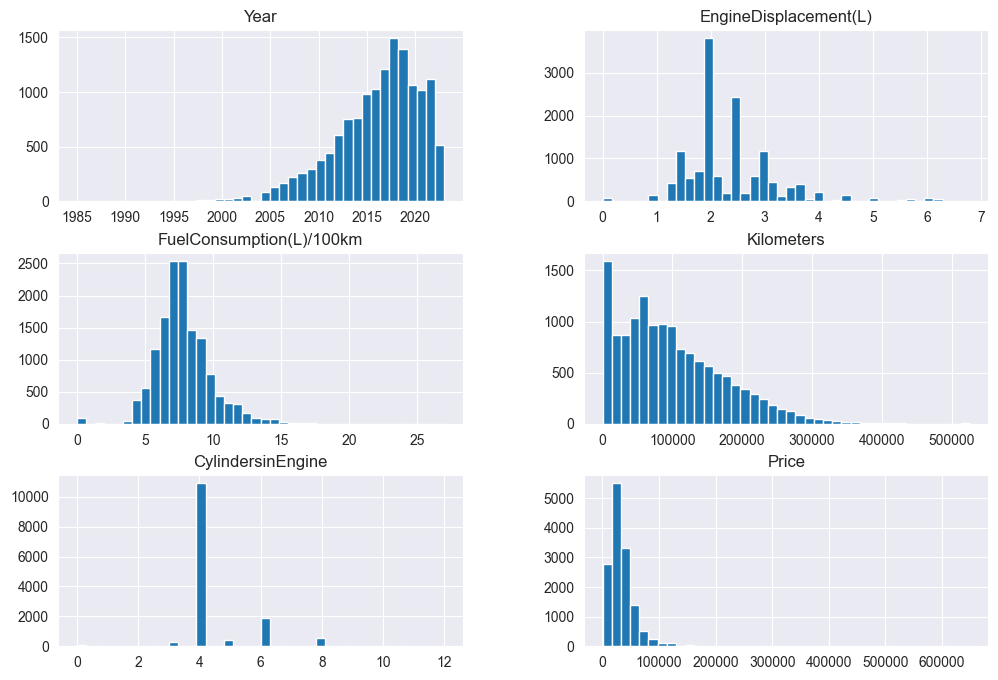

In [19]:
# getting a feel for the data distribution over the numerical features
df.hist(bins=40, figsize=(12,8))

In [20]:
# Reselecting
numeric_cols = df.select_dtypes(exclude='object').columns
categorical_columns = df.select_dtypes(include='object').columns

In [21]:
# Exploring correlation between numerical features
df[numeric_cols].corr()

,Year,EngineDisplacement(L),FuelConsumption(L)/100km,Kilometers,CylindersinEngine,Price
Year,1.000000,-0.216502,-0.397351,-0.745275,-0.220624,0.444705
EngineDisplacement(L),-0.216502,1.000000,0.766793,0.246908,0.851349,0.288900
FuelConsumption(L)/100km,-0.397351,0.766793,1.000000,0.338643,0.682550,0.095088
Kilometers,-0.745275,0.246908,0.338643,1.000000,0.160622,-0.433878
CylindersinEngine,-0.220624,0.851349,0.682550,0.160622,1.000000,0.313802
Price,0.444705,0.288900,0.095088,-0.433878,0.313802,1.000000


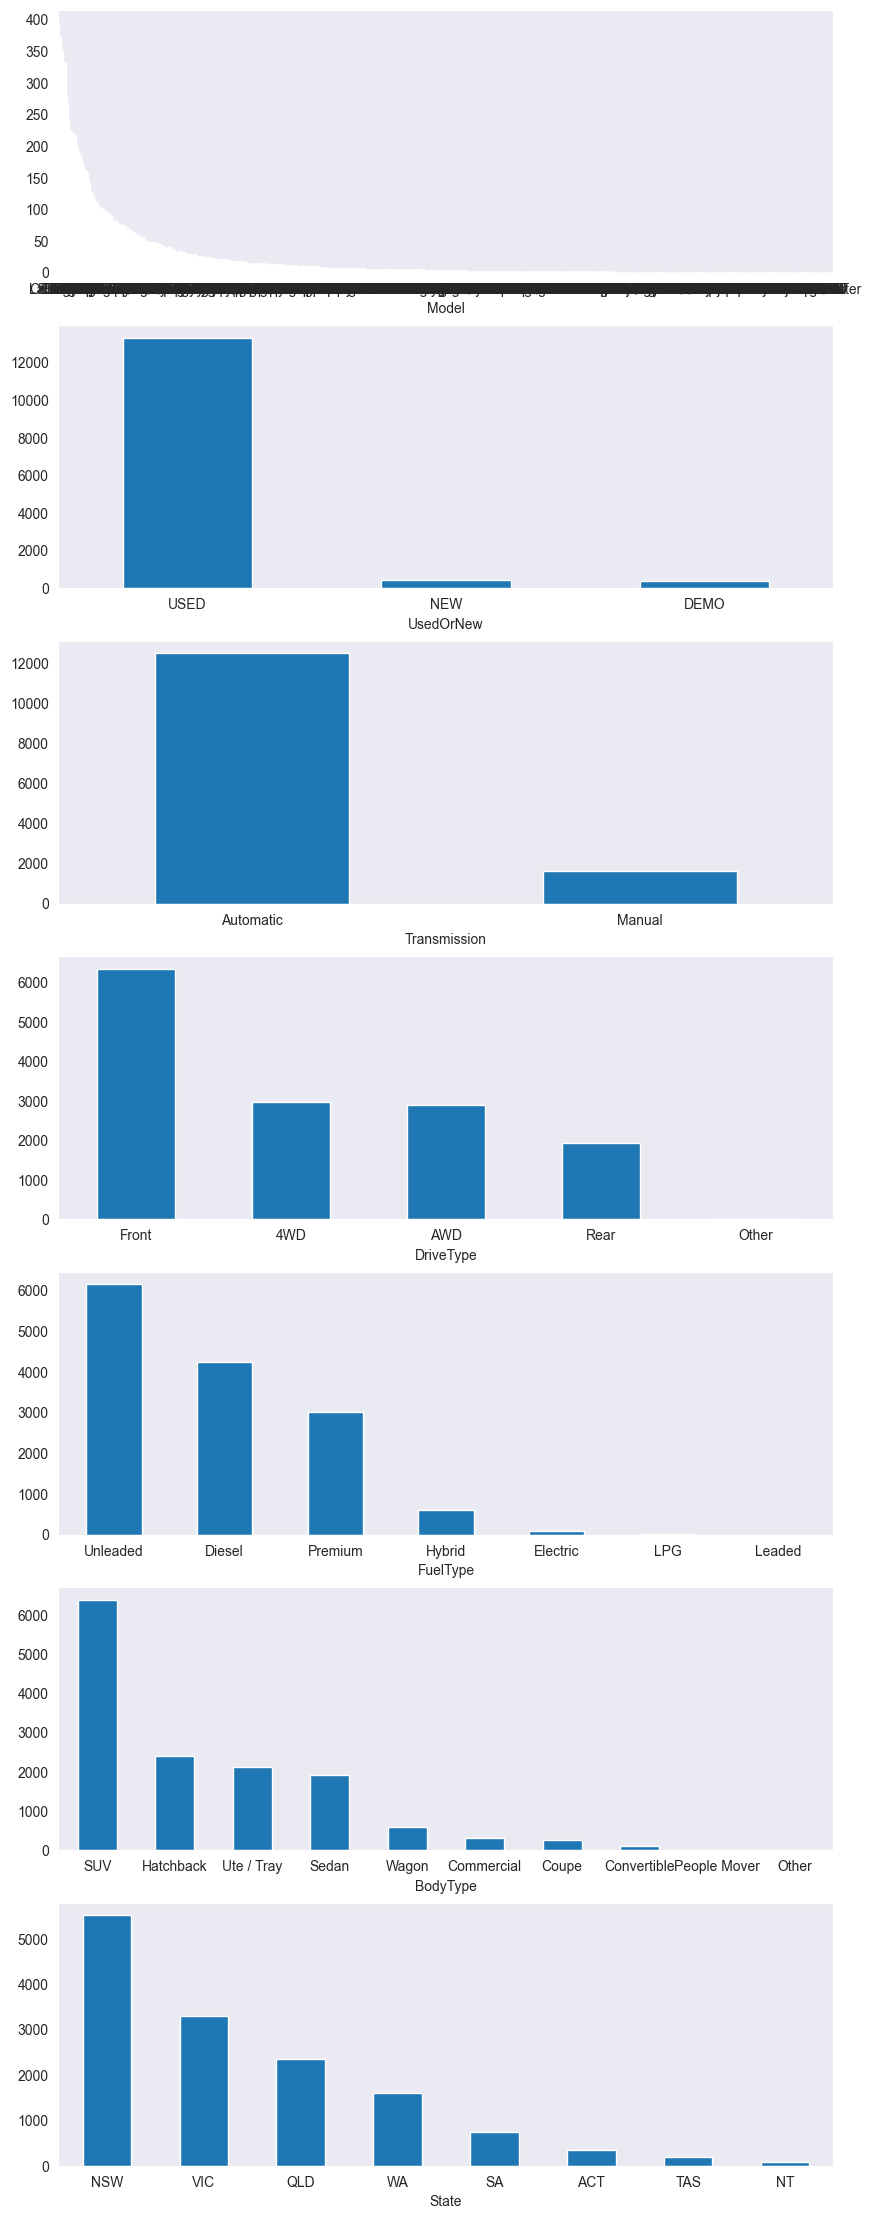

In [22]:
# Plotting the distribution of all categorical attributes occurances in the dataset
# Set up subplots
fig, axes = plt.subplots(nrows=len(categorical_columns), figsize=(10, 4 * len(categorical_columns)))

# Plot count plots for all categorical columns
for i, col in enumerate(categorical_columns):
    df[col].value_counts().plot(kind='bar', rot=0, ax=axes[i])

plt.show()

<Axes: xlabel='State', ylabel='Price'>

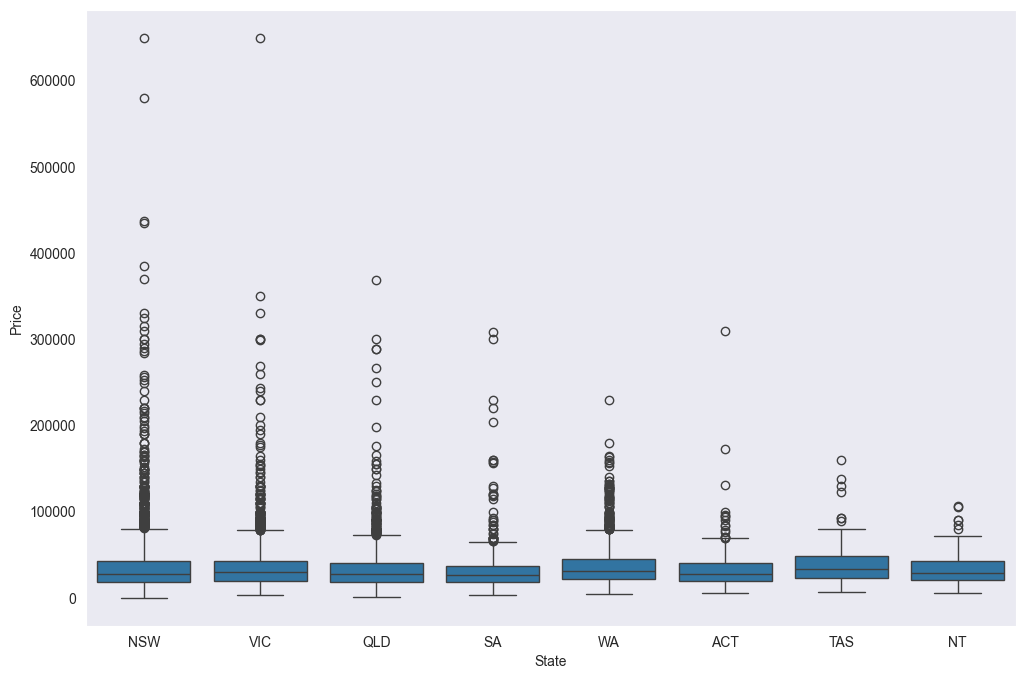

In [23]:
# Plotting all features against target feature
plt.figure(figsize=(12, 8))
sns.boxplot(x='State', y='Price', data=df)

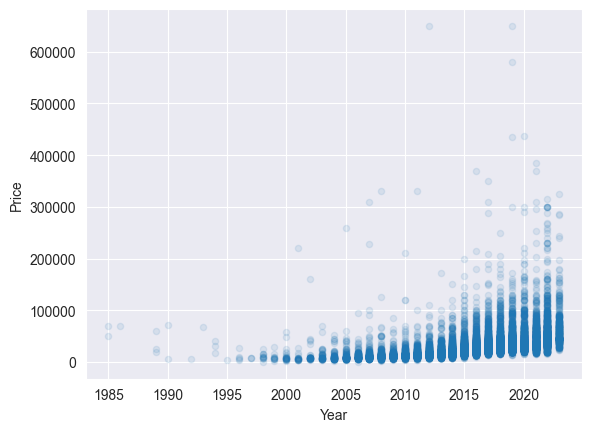

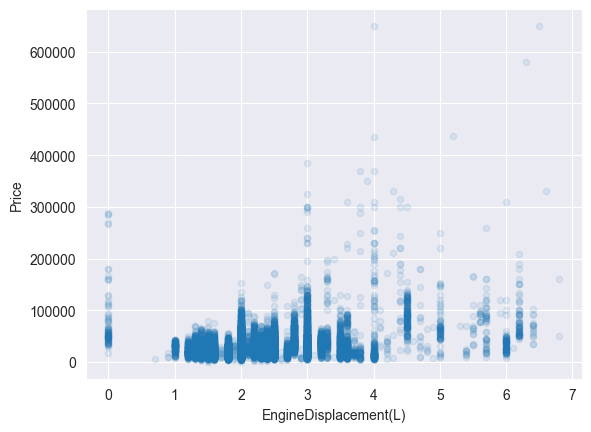

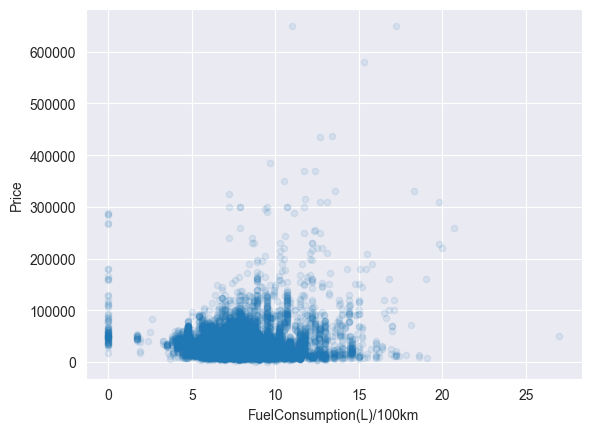

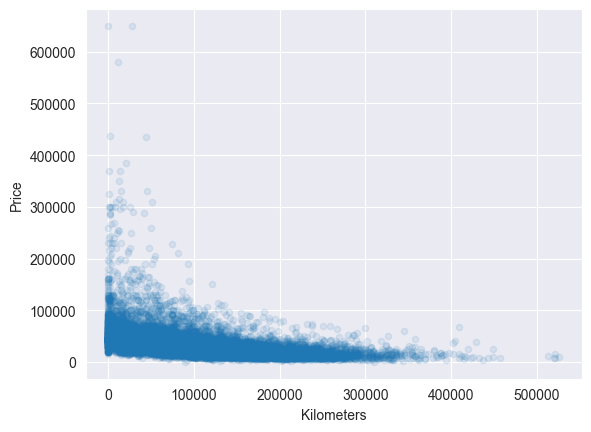

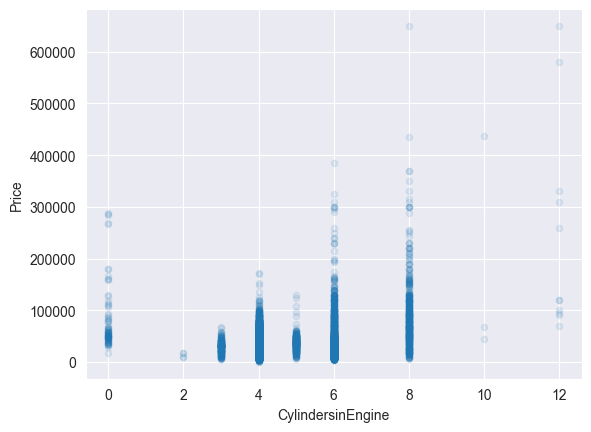

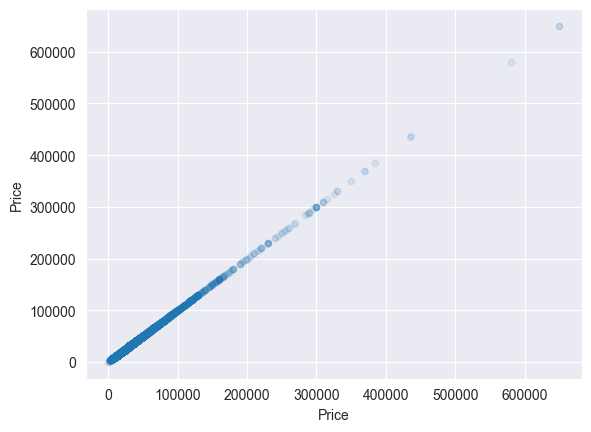

In [24]:
for col in numeric_cols:
    df.plot(kind='scatter', x=col, y='Price', alpha=0.1, grid=True)

# Data Modeling:

In [25]:
# dealing with data skew
df[numeric_cols].skew()

Year                       -0.992202
EngineDisplacement(L)       1.461935
FuelConsumption(L)/100km    0.649182
Kilometers                  0.922053
CylindersinEngine           1.591460
Price                       5.595892
dtype: float64

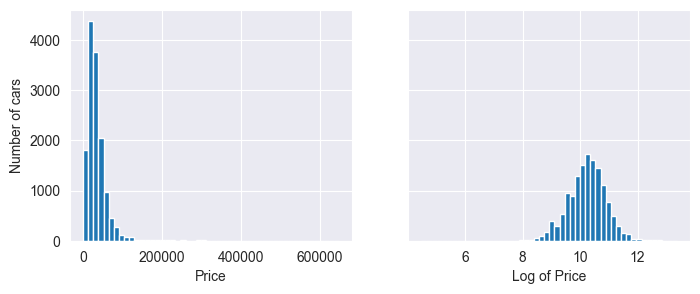

In [26]:
# High price skew, transforming to fit a Gaussian distribution
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
df["Price"].hist(ax=axs[0], bins=50)
df["Price"].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Price")
axs[1].set_xlabel("Log of Price")
axs[0].set_ylabel("Number of cars")
plt.show()

In [27]:
# Apparently, we would benefit indeed from logging the price
df['Price'] = df["Price"].apply(np.log)

In [28]:
# splitting into train-test sets
X = df.drop(columns = ['Price'], axis =1)
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [29]:
# Transformation pipelines
log_pipeline = make_pipeline(
    FunctionTransformer(func=np.log, feature_names_out='one-to-one'),
    StandardScaler()
)

cat_pipeline = make_pipeline(
    OneHotEncoder(handle_unknown='ignore')
)

num_pipeline = make_pipeline(
    StandardScaler()
)

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object))
)

# Modeling:

In [30]:
lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001E599852770>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001E599850B20>)])),
                ('linearregression', LinearRegression())])

In [31]:
df_predictions = lin_reg.predict(X_test)

In [32]:
# exploring predictions of Linear Regression
np.exp(df_predictions[:5]).round(-2)

array([13800., 39800., 28300., 35600., 85800.])

In [33]:
# Calculating MSE on original values
lin_rmse = mean_squared_error(y_true=np.exp(y_test), y_pred=np.exp(df_predictions), squared=False)
lin_r2 = r2_score(y_true=np.exp(y_test), y_pred=np.exp(df_predictions))
print(lin_rmse, lin_r2)

13490.282746899096 0.7311694934548246


the predictions are off by an average of ~$13,599 for the linear regression model. That's an accuracy of 72%. Let's attempt other regression models.

In [34]:
models = {
    'Random Forest': RandomForestRegressor(),
    'Decision Tree': DecisionTreeRegressor(),
    'Ada Boost': AdaBoostRegressor(),
    'Gradient Boost': GradientBoostingRegressor(),
    'XG Boost': xb.XGBRegressor()
}

for name, model in models.items():
    model_pipeline = make_pipeline(preprocessing, model)
    model_pipeline.fit(X_train, y_train)
    df_predictions = model_pipeline.predict(X_test)
    
    rmse = mean_squared_error(y_true=np.exp(y_test), y_pred=np.exp(df_predictions), squared=False)
    r2 = r2_score(y_true=np.exp(y_test), y_pred=np.exp(df_predictions))
    
    print(f"{name} model results:", '\n', f'RMSE: {rmse}', '\n', f'Accuracy:{r2}', "\n" + "=" * 30 + "\n")

Random Forest model results: 
 RMSE: 10975.055615604264 
 Accuracy:0.8220697023798103 

Decision Tree model results: 
 RMSE: 12302.738100998016 
 Accuracy:0.7764163696168624 

Ada Boost model results: 
 RMSE: 16169.658896739993 
 Accuracy:0.6137769735150234 

Gradient Boost model results: 
 RMSE: 13216.418745091287 
 Accuracy:0.7419736693988706 

XG Boost model results: 
 RMSE: 10738.544642177703 
 Accuracy:0.8296558201338788 



The best model is XGBoost, with an accuracy of 83%. Possible improvements include (from better to worse):
+ Including the ['Title'] column, and extracting the trim out of the column for each model.
+ Gathering additional data from other datasets.
+ Fine-tuning the model using cross-validation and grid-search.